In [16]:
list.of.packages = c('tidyverse', 'caret', 'gridExtra', 
                     'glmnet', 'cluster', 'mclust')
new.packages = list.of.packages[!(list.of.packages %in% 
                          installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, 
                      repos='http://cran.us.r-project.org')

options(warn=-1)
    
suppressWarnings(library(tidyverse, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(caret, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(require(gridExtra, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(glmnet, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(cluster, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(mclust, quietly = TRUE, warn.conflicts = FALSE))

set.seed(2718281)


In this module we will see how one can use dimensionality reduction to visualize high dimensional data. 

The data is a sample of the InstaCart dataset where we sample the top 5,000 active users and the 997 most popular products.

Any given row in the data frame refers to whether that individual purchased a product represented in the column or not.

In [17]:
choices = read.csv('Choice_Mat.csv')
choices = choices[which(apply(choices,2,var)!=0)]
# Reads csv files into R
choices[1:5,990:997]                                                            
# Examine the first few rows of our data
cat('Dataset dimesions: ',dim(choices))                                  
# Returns the dimension of the dataset 
                                        

X992,X993,X994,X995,X996,X997,X998,X999
0,0,0,0,0,1,1,0
0,0,0,0,1,0,0,1
0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,1,0


Dataset dimesions:  5000 997

We can get a pretty good idea of the sparsity in this data by looking at a binary heatmap

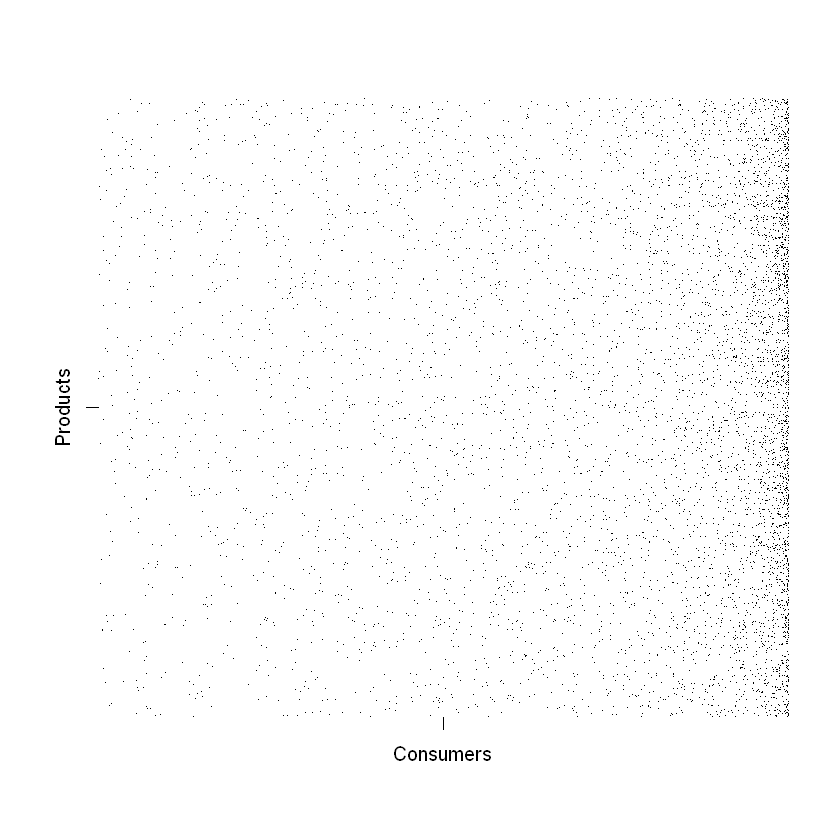

In [31]:
image(t(as.matrix(choices)),col=gray.colors(2,start=1,end=0),axes=FALSE)
axis(1,at = 0.5, label='Consumers',pos=0)
axis(2,at = 0.5,label='Products',pos=0)

The data is sorted based on the popularity, as one will observe from the density there is long tail behavior in the product purchases.

Our goal with dimensionality reduction is to find some inherent structure in this high dimensional data that can be exploited in our further analysis. The oldest and most widely used method to do this is to use PCA (principal components analysis)


In [4]:
pca = prcomp(choices,center=FALSE)
# decompose the choice matrix and compute the principal components

For visualization purposes we want to look at the data in 2 dimensions. To do this we can project the data onto the space corresponding to the first two principal components.

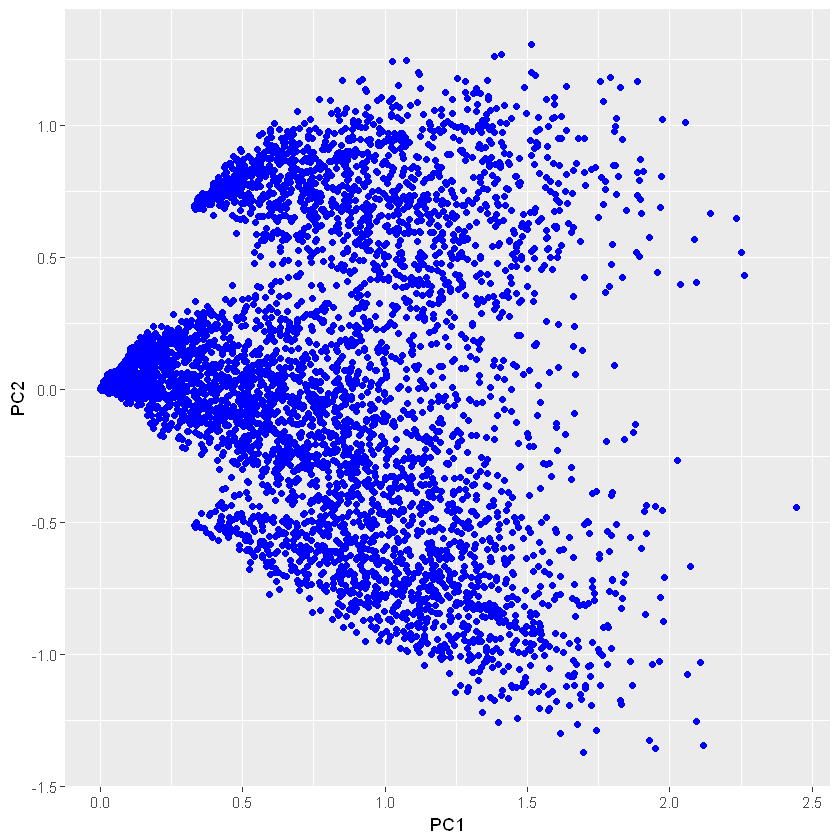

In [5]:

project = pca$rotation[,1:2]                             
# eigenvectors corresponding to first two principal components
project = data.frame(as.matrix(choices)%*%project)       
# project into two dimensions
ggplot(project, aes(PC1,PC2)) + geom_point(col='blue')


These clusters aren't necessarily the most well defined, but there appears to be some sort of structure to the data.

We don't want to arbitrarily assign groups based on visual inspection, so using a clustering algorithm on this lower dimensional representation is a good idea. There are many clustering algorithms to choose from. Some of the most common are Gaussian Mixture Models (GMM) and K-Means.

In addition to choosing the clustering algorithm one typically selects the number of clusters. (There are algorithms where instead one will choose the size of the neighborhood)

Let's look at GMM and K-Means where the optimal number of clusters is chosen through cross-validation based on the Silhouette Coefficient ( A measure of cluster separation and tightness ) 

In [6]:
# Defining a metric for "closest cluster" to assign test data to clusters

closest.cluster = function(x) {
  cluster.dist = apply(km$centers, 1, function(y) sqrt(sum((x-y)^2)))
  return(which.min(cluster.dist)[1])
}

# This is the same code as we used in the cross-validation module, 
# but a clustering algorithm instead of OLS

num_clust = 10                          
num_folds = 5  
sel = diag(num_folds)                                      
size = round(dim(project)[1]/num_folds)                
train = array(,dim=c(size*(num_folds-1),2,num_folds))      
test = array(,dim=c(size,2,num_folds))                     
sil = array(,c(num_folds,num_clust))                                
for (j in 2:num_clust){
    for (i in 1:num_folds){                                    
        test[,,i] = as.matrix(project)[as.logical(
            kronecker(array(1,c(size,1)),sel[i,])),]
        train[,,i] = as.matrix(project)[as.logical(
            kronecker(array(1,c(size,1)),(1-sel[i,]))),]
        train_tmp = data.frame(train[,,i])
        test_tmp = data.frame(test[,,i])
        
        # changes start here
        
        km = kmeans(train_tmp,j,nstart=10,iter.max=100)       
        # k-means algorithm with 10 restarts (pick best)
        clusters = apply(test_tmp, 1, closest.cluster)        
        # metric to assign test data to clusters 
        sil_tmp = silhouette(clusters,dist(test_tmp))         
        # compute silhouette for test data
        sil[i,j] = mean(sil_tmp[,3])
    }
}

In [7]:
cat('Lowest Silhouette achieved with', which.min(colMeans(sil)), 'Clusters')

Lowest Silhouette achieved with 9 Clusters

Now that we have optimized let's see what clusters were identified

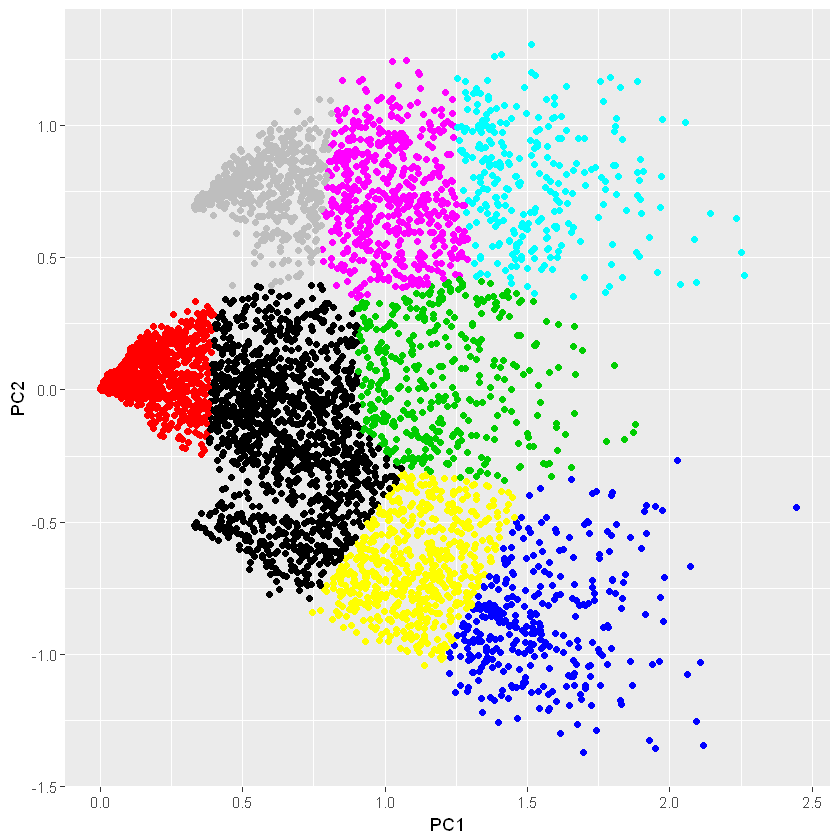

In [8]:
km = kmeans(project,which.min(colMeans(sil)),nstart=10,iter.max=100)
ggplot(project, aes(PC1,PC2)) + geom_point(col=km$cluster)

Alternatively we can use a GMM clustering algorithm. This is very easy to implement in R using the Mclust package.

In [9]:
gmm = Mclust(project)

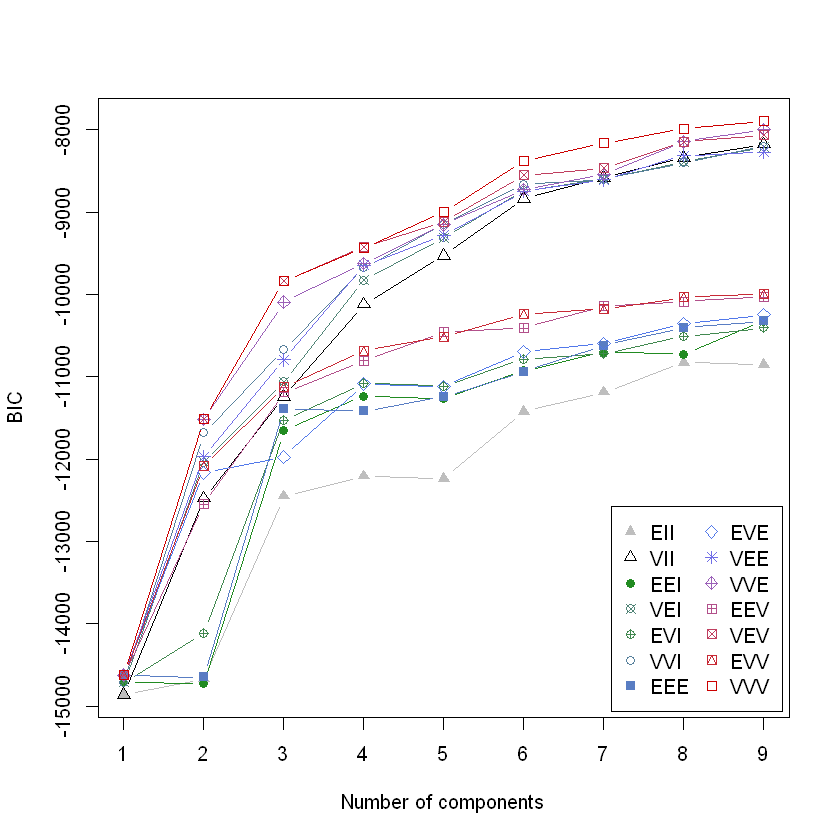

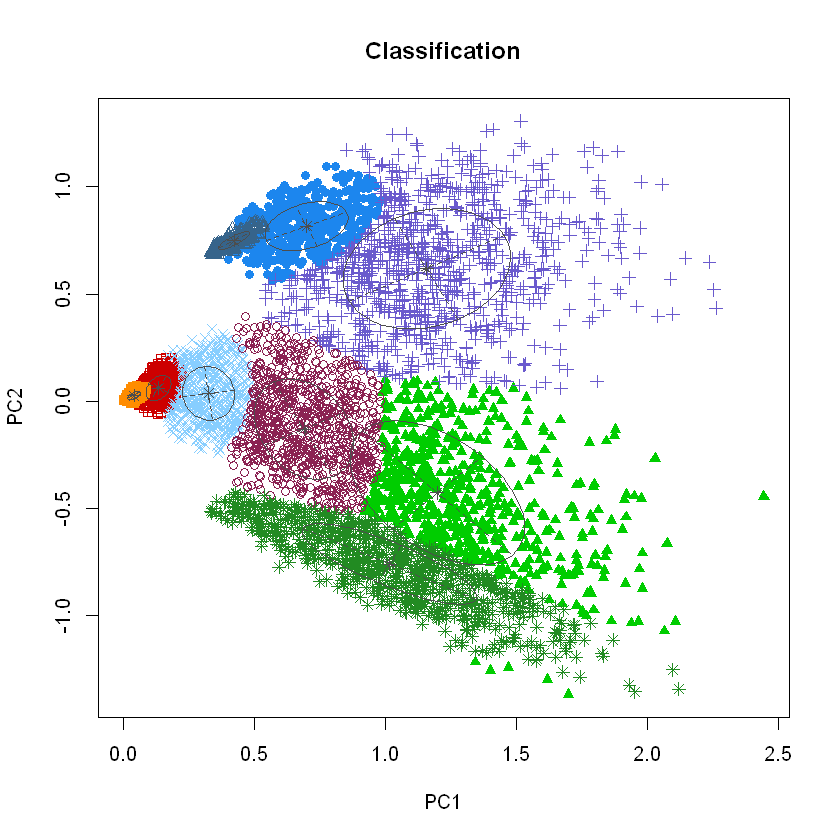

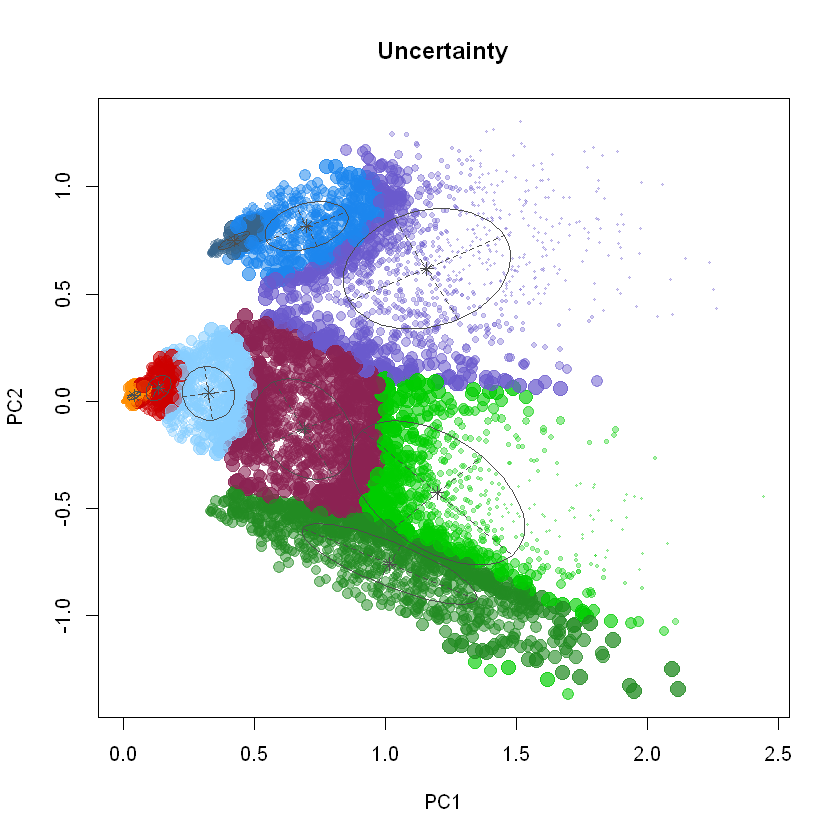

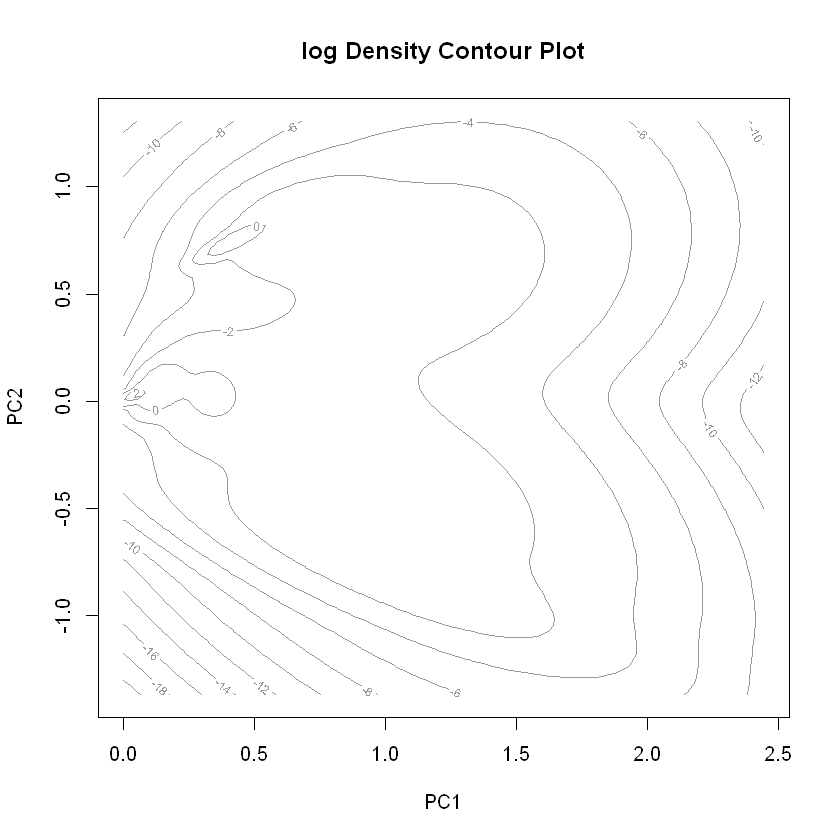

In [10]:
plot(gmm)

Using the GMM clustering algorithm ends up with the same number of clusters, but assignment is not identical. One thing that is nice about GMM is that you do get a measure of uncertainty when you compute cluster assignment. 


We can also determine an optimal dimensionality reduction by looking at the scree plot (the magnitude of the ordered eigenvalues).

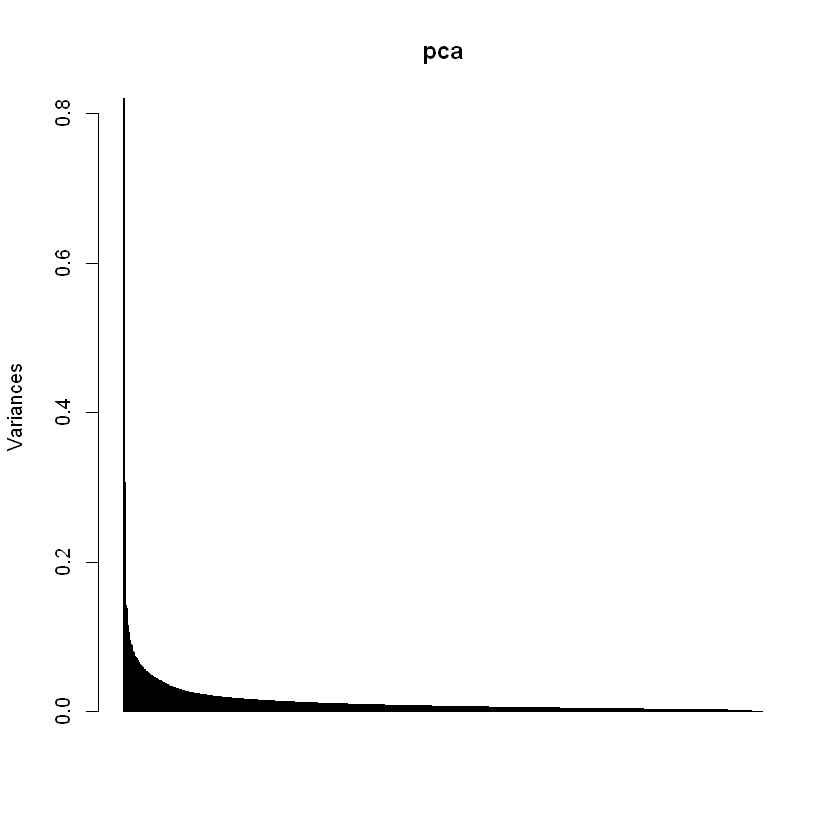

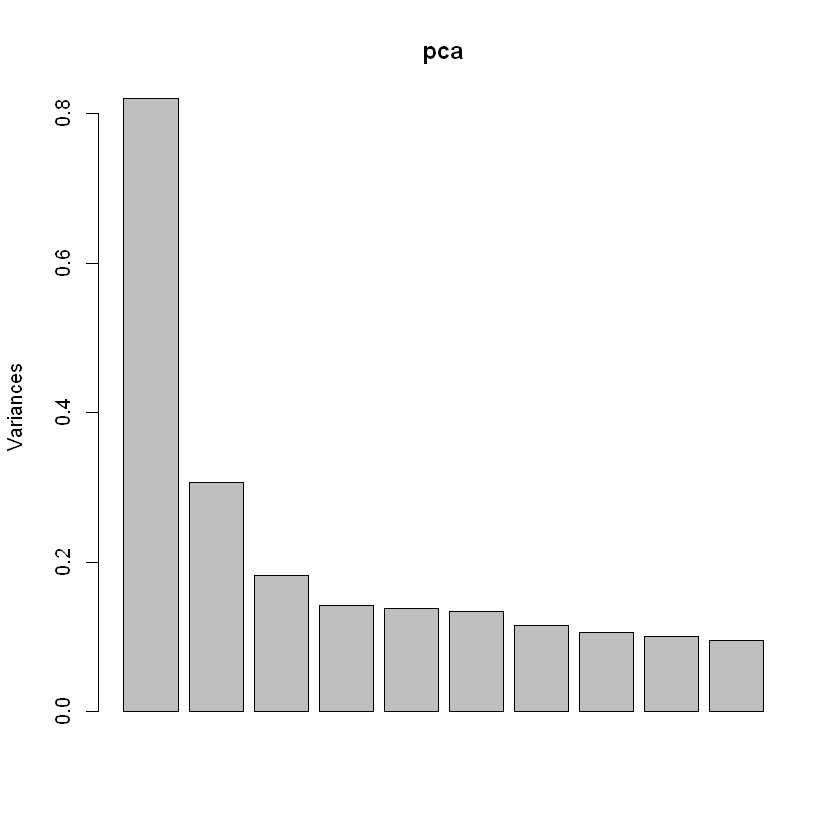

In [11]:
screeplot(pca,npcs=1000)
screeplot(pca,npcs=10)

The first image shows the scree plot for all of the eigenvalues and the second for only the first $10$. 

We see that a lot of the variation is explained by only a few components.

EXERCISE:

Instead of computing the principal components using the sample covariance matrix. Use the decomposition based on the correlation matrix. (This can be done by changing scale=TRUE in prcomp)

Project the data down to 2 dimensions and run GMM on the low dimensional data. Do you observe a different lower dimensional representation?